#### Step 1: explain the data
- what is included
- how it was obtained
- all important details about how it was sampled from the student's own digital archive.

**Objective for draft 1**

**Data Description**




To create a structured dataset of song lyrics, combines data from Spotify and Genius
I start with using Spotify’s API (via the Spotipy library) to extract detailed metadata from my playlists, including track names and artist information. 
With this metadata, I then use the Genius API (accessed through the LyricsGenius library) to search for and retrieve the corresponding lyrics for each song. 
The lyrics that can be found are saved as individual text files in a dedicated folder called 'lyrics'.

By leveraging these public APIs, we automate the extraction and aggregation of diverse musical content, making the dataset creation process efficient and scalable. 
Storing the lyrics locally allows us to apply standard data cleaning and exploratory analysis techniques using libraries like NLTK and pandas. 

In [ ]:
import os
import re
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import lyricsgenius

# -----------------------------
# Configure your API credentials
# -----------------------------
SPOTIPY_CLIENT_ID = 'b24b47adb2a94676bb924ab070b186f9'
SPOTIPY_CLIENT_SECRET = 'eb2285b6e27b4d4886b4f1c4ea008671'
SPOTIPY_REDIRECT_URI = 'http://localhost:8888/callback'
SCOPE = 'playlist-read-private'

GENIUS_ACCESS_TOKEN = '1OtAs6c9WU0RNaQHbO2evkUNLJfexp7n9Yjw1UkiMlM9Eier_lYN20odi0gQZfwu'

# -----------------------------
# Initialize the Spotify and Genius client
# -----------------------------
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
    client_id=SPOTIPY_CLIENT_ID,
    client_secret=SPOTIPY_CLIENT_SECRET,
    redirect_uri=SPOTIPY_REDIRECT_URI,
    scope=SCOPE
))

genius = lyricsgenius.Genius(GENIUS_ACCESS_TOKEN, timeout=15, sleep_time=1)


def fetch_and_save_lyrics(sp, genius, playlist_id, save_folder):
    # Define the parent 'dataset' folder
    dataset_folder = "dataset"

    # Ensure the 'dataset' folder exists
    if not os.path.exists(dataset_folder):
        os.makedirs(dataset_folder)

    # Define the full path where lyrics should be saved
    full_save_folder = os.path.join(dataset_folder, save_folder)

    # Check if the lyrics folder exists in 'dataset'
    if not os.path.exists(full_save_folder):
        os.makedirs(full_save_folder)
        print(f"Created folder: {full_save_folder}")
    else:
        print(f"Folder already exists: {full_save_folder}")

    # Path to store previously searched songs
    searched_songs_file = os.path.join(full_save_folder, "searched_songs.txt")

    # Load previously searched songs into a set
    searched_songs = set()
    if os.path.exists(searched_songs_file):
        with open(searched_songs_file, "r", encoding="utf-8") as f:
            searched_songs = set(line.strip() for line in f)

    # Retrieve tracks from the playlist
    results = sp.playlist_items(playlist_id)
    tracks = results['items']

    # Fetch additional pages if available
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])

    # Create a list to store track metadata
    track_list = []

    print("Retrieving tracks from the Spotify playlist:")
    for item in tracks:
        track = item['track']
        track_name = track['name']
        artist_name = track['artists'][0]['name']  # Taking the first artist for simplicity
        track_list.append({'track_name': track_name, 'artist_name': artist_name})
        print(f" - {track_name} by {artist_name}")

    # Fetch and save lyrics for each track using Genius
    print("\nFetching and saving lyrics for each track:")
    for track in track_list:
        track_name = track['track_name']
        artist_name = track['artist_name']

        # Generate a unique key for tracking searches
        song_key = f"{artist_name} - {track_name}"

        # Skip if the song was already searched
        if song_key in searched_songs:
            print(f"Already searched '{track_name}' by {artist_name}. Skipping.")
            continue

        # Sanitize the filename by removing illegal characters
        safe_track_name = re.sub(r'[\\/*?:"<>|]', "", track_name)
        safe_artist_name = re.sub(r'[\\/*?:"<>|]', "", artist_name)
        filename = os.path.join(full_save_folder, f"{safe_artist_name}_{safe_track_name}.txt")

        try:
            # Search for the song on Genius
            song = genius.search_song(track_name, artist_name)

            # Log the search attempt
            with open(searched_songs_file, "a", encoding="utf-8") as f:
                f.write(song_key + "\n")

            if song:
                # Check if the lyrics contain at least one Chinese character
                if not re.search(r'[\u4e00-\u9fff]', song.lyrics):
                    print(f"'{track_name}' by {artist_name} does not appear to be in Chinese. Skipping.")
                    continue
                with open(filename, "w", encoding="utf-8") as f:
                    f.write(song.lyrics)
                print(f"Saved lyrics for '{track_name}' by {artist_name} to {filename}")
            else:
                print(f"Lyrics not found for '{track_name}' by {artist_name}.")
        except Exception as e:
            print(f"Error retrieving lyrics for '{track_name}' by {artist_name}: {e}")

In [ ]:
fetch_and_save_lyrics(sp, genius, 'spotify:playlist:5xyY8qvuTT3bu7I4EZrrK8', "hope")
fetch_and_save_lyrics(sp, genius, 'spotify:playlist:26wLPbk8pEGACMWLLQ6zAo', "breakup")
fetch_and_save_lyrics(sp, genius, 'spotify:playlist:5NnmaHZisIOkTSQHrQySkN', "breakup")
fetch_and_save_lyrics(sp, genius, 'spotify:playlist:4Vh7HQNrLVxLTTlHU2HD9G', "nostalgia")
fetch_and_save_lyrics(sp, genius, 'spotify:playlist:4wMV6VuktylzFKffYR0NCs', "nostalgia")
fetch_and_save_lyrics(sp, genius, 'spotify:playlist:1PVFBy9S4DaoKBwwDydlcg', "inlove")

Retrieving tracks from the Spotify playlist:
 - 夜空中最亮的星 by 逃跑计划EscapePlan
 - 稻香 by Jay Chou
 - 裂縫中的陽光 by JJ Lin
 - 喝采 by Danny Chan
 - 蒙著嘴說愛你 by Keung To
 - 相信 by sodagreen
 - Everytime by CHEN
 - 假使世界原來不像你預期 by Charmaine Fong
 - 點一把火炬 by JJ Lin
 - It’s OK To Be Sad by Janice Vidal
 - 生命有價 by Lil’ Ashes
 - 未知道 by 陳健安
 - Dear My Friend, by Keung To
 - 致明日的舞 by Eason Chan
 - 神奇之路 (電影《媽媽的神奇小子》主題曲) by 柳應廷
 - Be True by Joey Yung
 - 凡星 by Panther Chan
 - 相信一切是最好的安排 by Panther Chan
 - 造夢時學會飛行 - "聲夢傳奇"主題曲 by "聲夢傳奇" 學員
 - 愛與希望 by JJ Lin
 - 加油! by JJ Lin
 - 孤獨病 by Keung To
 - 滯留鋒 by 理想混蛋
 - 留一天與你喘息 by 陳卓賢 Ian
 - 好想愛這個世界啊 by Hua Chen Yu
 - 最好時光 by Joey Yung
 - Gotta Go! by COLLAR
 - 我的驕傲 by Joey Yung
 - Hey u by Charmaine Fong
 - Tomorrow by AGA
 - 對得起自己 by Jason Chan
 - 記得 by Terence Lam
 - 呼吸之間 by Janice Vidal
 - We All Are by MIRROR
 - 晚安歌 by Ella Chen
 - The Bright Side by COLLAR
 - 不枉 by Andy Hui
 - 聖馬力諾之心 by Dear Jane
 - 繼續繼續 by 陳健安
 - 青年危機 by Panther Chan
 - 與眾不同 (ViuTV 節目 "8%的聲音" 主題曲) - 

In [ ]:
fetch_and_save_lyrics(sp, genius, 'spotify:playlist:1N1fFRBzsWliaZper3WB9F', "breakup")
fetch_and_save_lyrics(sp, genius, 'spotify:playlist:0D3ObU8Bq3FWy7aHjayLf9', "nostalgia")

Folder already exists: dataset/breakup
Retrieving tracks from the Spotify playlist:
 - 妳幸福嗎？ by Hubert Wu
 - 到此為止 by Shiga Lin
 - 六天 by Pakho Chau
 - 殘酷遊戲 by Janice Vidal
 - 年青有為 by Feng Ze
 - 連名帶姓 by A-Mei Chang
 - 晴天 by Jay Chou
 - 眼淚記得你 - 電影《想見你》主題曲 by Shi Shi
 - 我愛的人 by Yoga Lin
 - 年少有為 by Ronghao Li
 - 我夢見你夢見我 by Yoga Lin
 - 我不想你想你了 by 831
 - 殘酷月光 by Yoga Lin
 - 當我們不在一起 by Quarterback
 - 倒帶 by Jam Hsiao
 - 我已經敢想你 by Yoga Lin
 - 壞與更壞 by Yoga Lin
 - 說謊 by Yoga Lin
 - 浪費 by Yoga Lin
 - 神秘嘉賓 by Yoga Lin
 - 最後一堂課 - 《媽，別鬧了！》影集片尾曲 by Eric Chou
 - 珊瑚海 by Jay Chou
 - 擱淺 by Jay Chou
 - 不該 (with aMEI) by Jay Chou
 - 最長的電影 by Jay Chou
 - 後來的我們 by Mayday
 - 突然好想你 by Mayday
 - 過路人 by Shiga Lin
 - 知足(07'最知足版) by Mayday
 - 如這麼愛他 by Hubert Wu
 - 我還想她 by JJ Lin
 - 後來 by Rene Liu
 - 我知道要微笑 by Eric Chou
 - 到此為止 by Shiga Lin
 - 小幸運 - 電影《我的少女時代》主題曲 by Hebe Tien
 - 忽而今夏(电视剧<忽而今夏>同名主题曲) by Silence Wang
 - 微不足道的小事是我還愛著你 (電視劇《忽而今夏》片尾曲) by 張磊
 - 再不再見 by C AllStar
 - 可惜沒如果 by JJ Lin
 - 怎麼了 by Eric Chou
 - 至少

#### Step 2: Data Ingestion
- converting this data to Python readable format (and sci-kit-learn) 
- loading this data into an appropriate data structure (np.array, pandas dataframe, glob etc.).


In [49]:
import os
import pandas as pd
import glob

def load_lyrics_data(root_folder="dataset"):
    """
    Loads song lyrics from text files stored in category-based subfolders.
    """
    data = []
    for category in os.listdir(root_folder):
        folder = os.path.join(root_folder, category)
        if os.path.isdir(folder):
            for filepath in glob.glob(os.path.join(folder, "*.txt")):
                with open(filepath, 'r', encoding='utf-8') as file:
                    lyrics = file.read().strip()
                data.append({
                    "filename": filepath,
                    "lyrics": lyrics,
                    "label": category
                })
    
    return pd.DataFrame(data)

df = load_lyrics_data()
print("Loaded data:")
print(df.head())

Loaded data:
                                     filename  \
0         dataset/inlove/Elva Hsiao_愛的主打歌.txt   
1  dataset/inlove/Tyson Yoshi_To My Queen.txt   
2               dataset/inlove/Young_天生一對.txt   
3     dataset/inlove/Panther Chan_我想和你好好的.txt   
4            dataset/inlove/Fish Leong_勇氣.txt   

                                              lyrics   label  
0  1 Contributor愛的主打歌 (Theme Song of Love) Lyrics...  inlove  
1  3 ContributorsTo My Queen Lyrics[Tyson Yoshi「T...  inlove  
2  2 Contributors天生一對 (Meant to Be) Lyrics陽光讓空氣 充...  inlove  
3  1 Contributor我想和你好好的 (I Wanna Be With You) Lyr...  inlove  
4  1 Contributor勇氣 (Courage) Lyrics[梁靜茹 “勇氣” 歌詞]\...  inlove  


In [50]:
print(df['label'].value_counts())

label
inlove       65
breakup      64
hope         52
nostalgia    49
Name: count, dtype: int64


In [51]:
from sklearn.utils import resample

def balance_dataset(df, method="undersample"):
    """
    Balances the dataset so that all categories have the same number of samples.
    Options:
    - "undersample": Reduce larger categories to match the smallest one.
    - "oversample": Increase smaller categories to match the largest one.
    """
    if df.empty:
        print("Dataset is empty. Nothing to balance.")
        return df

    category_counts = df['label'].value_counts()
    min_samples = category_counts.min()
    max_samples = category_counts.max()

    if method == "undersample":
        # Reduce all categories to match the smallest one
        df_balanced = df.groupby('label', group_keys=False).apply(lambda x: x.sample(n=min(len(x), min_samples), random_state=42))
    elif method == "oversample":
        # Increase all categories to match the largest one
        df_balanced = df.groupby('label', group_keys=False).apply(lambda x: resample(x, replace=True, n_samples=max_samples, random_state=42))
    else:
        raise ValueError("Invalid balance method. Choose 'undersample' or 'oversample'.")

    return df_balanced.reset_index(drop=True)

df_balanced = balance_dataset(df, method="undersample") 
print("Balanced dataset:")
print(df_balanced['label'].value_counts())


Balanced dataset:
label
breakup      49
hope         49
inlove       49
nostalgia    49
Name: count, dtype: int64


/var/folders/hb/vs0ptz7977jgj7hy5m4jjjt80000gn/T/ipykernel_60309/443425185.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('label', group_keys=False).apply(lambda x: x.sample(n=min(len(x), min_samples), random_state=42))


#### Step 3: Data Cleaning 
explaining any necessary cleaning, pre-processing, and feature engineering the data requires

+ [code block] completing these steps. 
perform some basic exploratory data analysis at this point reporting and visualizing the samples and computing appropriate descriptive statistics.

Data Cleaning:

The Natural Language Toolkit (NLTK) is a Python library for working with human language data. It provides tools for different natural language processing (NLP) tasks such as tokenization, stemming, lemmatization, parsing, and text classification. In this project, where the primary goal is to process and analyze song lyrics, NLTK helps to convert raw text into a clean, structured format that can be used for further analysis with machine learning. 

One of NLTK's greatest strengths is that it has a large collection of pre-built functions that can cater to almost every aspect of text processing, making it very versatile to experiment with different NLP tasks. In terms of weaknesses, NLTK can be slower compared to more modern libraries like spaCy when processing very large datasets, and it may consume more memory. Nevertheless, since this project only requires processing a moderate amount of lyrical data, the scope is appropriate for NLTK. 

The preprocess_lyrics function converts the text to lowercase, removes punctuation, tokenizes the text, filters out stopwords, and lemmatizes the words. These steps prepare the lyrics for feature extraction by standardizing and simplifying the text.

- Lowercase ensures uniformity.
- Punctuation removal cleans noise.
- Tokenization is the process of splitting a string of text into individual words or tokens. This function breaks down the lyrics into manageable units, which is crucial for subsequent steps like filtering and frequency analysis.
- nltk.corpus.stopwords is a module provides a list of common words that are often removed from text during preprocessing because they add little semantic value. Filtering out stopwords helps in reducing noise and focusing the analysis on the more meaningful content of the lyrics.
- Lemmatization reduces words to their base or dictionary form (e.g., "running" becomes "run"). This step is important to ensure that variations of the same word are treated as a single entity, which aids in creating more consistent features for further analysis.

these components allow us to transform raw song lyrics into a clean and structured format, setting a solid foundation for the rest of the machine learning pipeline. This detailed cleaning and preprocessing phase is crucial for ensuring that our model can effectively learn from the data and accurately match user-generated tags to the appropriate song lyrics.

In [52]:
import requests

# URL of the Chinese stopwords file (raw file from GitHub)
url = "https://raw.githubusercontent.com/goto456/stopwords/master/cn_stopwords.txt"

# Send a GET request to the URL
response = requests.get(url)

# Check if the download was successful
if response.status_code == 200:
    # Save the content to a file named "chinese_stopwords.txt"
    with open("chinese_stopwords.txt", "w", encoding="utf-8") as f:
        f.write(response.text)
    print("Downloaded Chinese stopwords successfully!")
else:
    print(f"Failed to download Chinese stopwords. Status code: {response.status_code}")

Downloaded Chinese stopwords successfully!


In [53]:
import re
import jieba

def load_chinese_stopwords(filepath):
    """
    Loads Chinese stopwords from a file.
    Assumes one stopword per line.
    """
    with open(filepath, 'r', encoding='utf-8') as f:
        stopwords = set(f.read().split())
    return stopwords

# Load Chinese stopwords from your provided file.
chinese_stopwords = load_chinese_stopwords("chinese_stopwords.txt")

def preprocess_lyrics_chinese(text):
    """
    Preprocess Chinese lyrics by:
    1. Splitting text into lines and optionally discarding a header.
    2. Removing lines with annotations in square brackets (e.g., [Chorus]).
    3. Rejoining the text and removing common Chinese and English punctuation.
    4. Tokenizing using jieba.
    5. Removing stopwords.
    6. Filtering out tokens that do not contain Chinese characters.
    Returns a space-separated string for feature extraction.
    """
    # 1. Split text into lines; remove header if needed
    lines = text.split('\n')
    if len(lines) > 0:
        lines = lines[1:]  # adjust if header is to be discarded

    # 2. Remove lines with annotations like [Chorus]
    filtered_lines = [line for line in lines if not re.search(r'\[.*?\]', line)]
    
    # 3. Rejoin into a single string
    cleaned_text = ' '.join(filtered_lines)
    
    # 4. Remove punctuation: expand to include parentheses and common English punctuation
    punctuation_pattern = r'[，。！？、；：“”‘’《》,!?.:;\'"()\[\]<>-]'
    cleaned_text = re.sub(punctuation_pattern, '', cleaned_text, flags=re.UNICODE)
    
    # 5. Tokenize using jieba
    tokens = jieba.lcut(cleaned_text)
    
    # 6. Remove stopwords
    tokens = [word for word in tokens if word not in chinese_stopwords]
    
    # 7. Filter tokens: keep only tokens that contain at least one Chinese character
    tokens = [word for word in tokens if re.search(r'[\u4e00-\u9fff]', word)]
    
    return " ".join(tokens)


# Apply preprocessing
df['processed'] = df['lyrics'].apply(preprocess_lyrics_chinese)
print("\nPreprocessed text sample:")
print(df[['label', 'processed']].head())


Preprocessed text sample:
    label                                          processed
0  inlove  唱 什麼 什麼 覺得 原來 原來 主打 歌 說 什麼 聽 一次 會 記得 聽 兩次 火熱 幹...
1  inlove  給你 真心 愛 命 請 真心 對待 情 幸福 一天 對 瘋癲 給你 真心 愛 命 請 真心 ...
2  inlove  初夏 回憶 滿滿 咖啡 秘方 用心 驚喜 身邊 轉身 做鬼 臉 傻氣 想要 珍惜 倔強 逞強...
3  inlove  曾約定 於 婚禮 中 穿 西裝獻奏 穿 婚紗獻 唱 誰 不知 一起 譜 寫 愛歌 現今 夜半...
4  inlove  終於 做 這個 決定 別人 怎麼 說 不理 一樣 肯定 我願意 天涯海角 隨 知道 容易 心...


Exploratory Data Analysis:

We compute the number of tokens for each song to get an idea of text length and processing success.
Additionally, we visualize the distribution of token counts and compute the most common words across the dataset to understand the general vocabulary and dominant themes present in the lyrics, as well as confirm that the cleaning steps retain relevant content.


Descriptive Statistics:
count    230.000000
mean     304.073913
std       91.919552
min        0.000000
25%      254.500000
50%      304.000000
75%      363.500000
max      550.000000
Name: num_tokens, dtype: float64


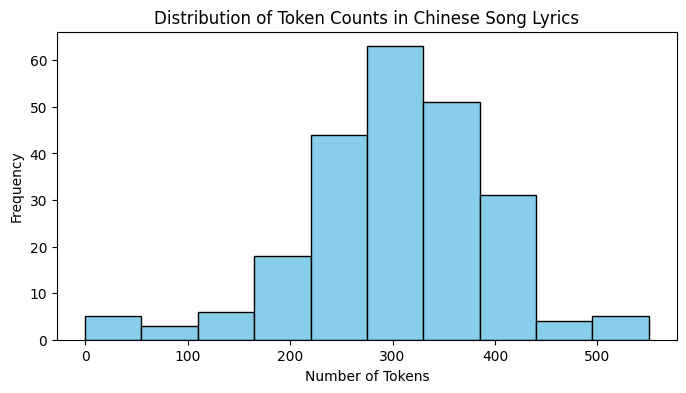


Most Common Words in the Chinese Lyrics Dataset:
說: 578
誰: 509
想: 456
後: 401
我們: 394
著: 346
對: 333
會: 331
愛: 322
於: 321


In [54]:
import matplotlib.pyplot as plt
from collections import Counter

# Calculate token counts per song (assuming tokens are separated by spaces)
df['num_tokens'] = df['processed'].apply(lambda x: len(x.split()))
print("\nDescriptive Statistics:")
print(df['num_tokens'].describe())

# Plot token count distribution
plt.figure(figsize=(8, 4))
plt.hist(df['num_tokens'], bins=10, color='skyblue', edgecolor='black')
plt.title("Distribution of Token Counts in Chinese Song Lyrics")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()

# Find most common words across all songs
all_tokens = [token for processed in df['processed'] for token in processed.split()]
word_counts = Counter(all_tokens)
common_words = word_counts.most_common(10)
print("\nMost Common Words in the Chinese Lyrics Dataset:")
for word, count in common_words:
    print(f"{word}: {count}")

***CHANGE***

[MIGHT modify the stopwords list by first converting it to a Python set and then updating it with the additional punctuation-stripped words.]

***[im, youre, well, na etc]***

One song has around 191 tokens, and the other has around 193, indicating that they are quite similar in length. 
Because we only have two songs in this assignment, the histogram of token counts naturally shows only two bars, offering little in terms of a broader distribution to compare. 
Nonetheless, it serves as a sanity check to confirm that our tokenization process worked correctly and that both lyrics files were successfully read.

Looking at the most common words, the top four—would, head, mine, and keep—all appear in the song titles. 
This is unsurprising, as song titles often recur in the lyrics (especially in the chorus or refrain). 
While these repetitions can reflect central themes of the songs, they may also bias any model that heavily relies on word frequency, potentially overshadowing deeper thematic content.

What I also notice is that single-word analysis can obscure context. 
For example, the word “time” could be used to discuss heartbreak in one song and hope or reflection in another. 
To capture more nuanced meaning, we might explore n-grams or advanced embeddings (such as BERT). 
N-grams (bigrams, trigrams) can retain short phrases that add context, whereas BERT inherently models word relationships at the sub-word level, reducing the need for explicit n-gram engineering. 

#### Step 4: Analysis
- discussing the analysis (classification, regression, or clustering) that will be conducted on the data
- code performs any necessary data splits (such as creating training and test sets)

The objective of assignment 1 is to predict which category a song belongs to (hope, growing up, breaking up, or love) based on its lyrics. 
This is a classification problem because the output is a discrete label chosen from a fixed set of categories. 
In classification tasks, it is critical that our input data is represented numerically, because most machine learning algorithms work with numerical vectors rather than raw text.
This allows models to detect patterns and associations between word usage and the song’s category, apply learned weights to new, unseen texts, and use optimization like gradient descent on continuous numerical data.

In [55]:
from sklearn.model_selection import train_test_split

# Explanation:
# X contains the processed lyrics (text transformed to a space-separated string after segmentation).
# y contains the corresponding labels (categories such as hope, growing up, breaking up, love).
X = df['processed']  # our preprocessed text data
y = df['label']      # the category labels

# We use train_test_split to create a training set and a test set.
# The test_size parameter is set to 0.2, meaning 20% of the data is reserved for testing.
# random_state is set for reproducibility.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Output the size of each split to confirm
print("Total samples:", len(df))
print("Training samples:", len(X_train))
print("Test samples:", len(X_test))

Total samples: 230
Training samples: 184
Test samples: 46


**explain why this number is sufficient**

#### Step 5: Model Selection

- discuss model** selection** in a markdown section 
- [code] model initialization and construction in a well-commented code block. 
- This section should include a clear discussion of the model's mathematical underpinnings -> include typeset equations and/or algorithms as pseudocode.


To convert to numbers, For naive bayes/MLP we are using Term Frequency–Inverse Document Frequency (TF‑IDF) and bert we are using Word Embeddings.

TF‑IDF is used to quantify the importance of a word in a document relative to a corpus. 
It helps to weigh down common words while highlighting words that are more distinctive.
For a character $c$ in a song's lyrics $l$, TF‑IDF is computed as:

$TF-IDF(t,d)=TF(t,d)×IDF(t)$, 

where: Term Frequency TF(t,d): $\frac{Number of times t appears in d},{Total number of terms in d}
and 


As a result, the text is transformed into a vector where each component represents the TF‑IDF value of a specific term. 
This fixed-length vector can be fed into traditional classifiers like Naive Bayes or MLP.


**elab (in relation to BERT)**
Word Embeddings provide a dense, continuous representation of words that capture semantic and syntactic information. 
Unlike TF‑IDF which results in a sparse vector with one dimension per vocabulary term, embeddings yield dense vectors that reflect relationships between words.
Models like Word2Vec, GloVe, or contextual embeddings from BERT transform each word into a vector (e.g., 300-dimensional). 
For a complete document, you might compute an aggregate representation by averaging these word vectors or using more sophisticated methods.
These representations can then be used as input features for various classifiers, or further fine-tuned in end‑to‑end deep learning models.

In [56]:
# For classical models, we use scikit-learn pipelines
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

# Naive Bayes Pipeline
nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', MultinomialNB())
])

# MLP Pipeline
mlp_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42))
])

In [57]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder

# Use a pre-trained Chinese BERT model
model_name = "bert-base-chinese"
tokenizer = BertTokenizer.from_pretrained(model_name)

# Encode labels into integers
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

# Define a custom Dataset for Trainer
class LyricsDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        # Squeeze to remove extra dimension
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# Split the data for BERT model as well
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['processed'], df['label_encoded'], test_size=0.2, random_state=42)

train_dataset = LyricsDataset(train_texts, train_labels, tokenizer)
test_dataset = LyricsDataset(test_texts, test_labels, tokenizer)

# Initialize the BERT model for sequence classification
num_labels = len(le.classes_)
bert_model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Step 6: train the model
- code and explanations for necessary cross validation or hyperparameter tuning.


In [58]:
# Training classical models
nb_pipeline.fit(X_train, y_train)
mlp_pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=5000)),
                ('clf', MLPClassifier(max_iter=300, random_state=42))])

In [60]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    seed=42,
)

trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()

Epoch,Training Loss,Validation Loss


RuntimeError: MPS backend out of memory (MPS allocated: 8.80 GB, other allocations: 239.72 MB, max allowed: 9.07 GB). Tried to allocate 96.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

#### Step 7: 
- code to generate predictions for out of sample data, and compute appropriate performance** metrics.**

In [44]:
from sklearn.metrics import classification_report

# --- Classical Models ---
# Naive Bayes predictions
y_pred_nb = nb_pipeline.predict(X_test)
print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))

# MLP predictions
y_pred_mlp = mlp_pipeline.predict(X_test)
print("MLP Classification Report:")
print(classification_report(y_test, y_pred_mlp))

# --- BERT Model ---
# Use Trainer to evaluate BERT
eval_result = trainer.evaluate()
print("BERT Evaluation Results:")
print(eval_result)

Naive Bayes Classification Report:
              precision    recall  f1-score   support

     breakup       0.89      0.50      0.64        16
        hope       0.50      0.18      0.27        11
      inlove       0.29      1.00      0.45         9
   nostalgia       0.50      0.10      0.17        10

    accuracy                           0.43        46
   macro avg       0.54      0.45      0.38        46
weighted avg       0.59      0.43      0.41        46

MLP Classification Report:
              precision    recall  f1-score   support

     breakup       1.00      0.56      0.72        16
        hope       0.62      0.45      0.53        11
      inlove       0.43      1.00      0.60         9
   nostalgia       0.62      0.50      0.56        10

    accuracy                           0.61        46
   macro avg       0.67      0.63      0.60        46
weighted avg       0.72      0.61      0.61        46



KeyboardInterrupt: 

**unbalanced class size!!!! --> 0**

#### Step 8: visualize the results and discuss your conclusions.

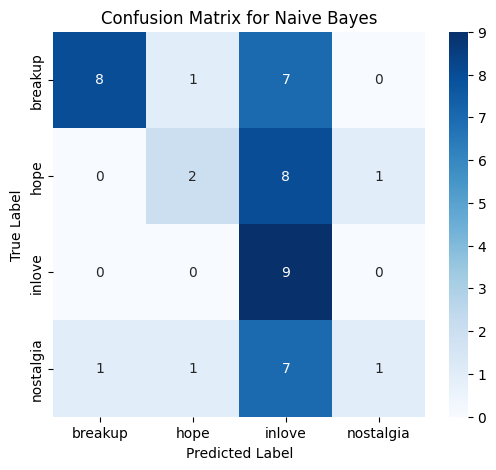

'\n**Discussion:**\n- The classical models (Naive Bayes and MLP) use TF‑IDF features and provide a simple baseline.\n- The BERT model, after fine-tuning, tends to capture richer semantics but requires more resources.\n- The confusion matrix above shows where misclassifications occur.\n- Potential shortcomings include insufficient data in certain categories, or noisy lyrics that can affect performance.\n- Future improvements might involve data augmentation, more advanced preprocessing (e.g., handling mixed language), or further tuning of BERT hyperparameters.\n'

In [46]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# For classical models, e.g., using Naive Bayes predictions:
cm = confusion_matrix(y_test, y_pred_nb)
#cm = confusion_matrix(y_test, y_pred_nb, labels=le.transform(le.classes_))
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix for Naive Bayes")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Discussion (in Markdown):
"""
**Discussion:**
- The classical models (Naive Bayes and MLP) use TF‑IDF features and provide a simple baseline.
- The BERT model, after fine-tuning, tends to capture richer semantics but requires more resources.
- The confusion matrix above shows where misclassifications occur.
- Potential shortcomings include insufficient data in certain categories, or noisy lyrics that can affect performance.
- Future improvements might involve data augmentation, more advanced preprocessing (e.g., handling mixed language), or further tuning of BERT hyperparameters.
"""


#### Step 9: executive summary (of the prior eight sections)
- clearly explaining your steps
- diagramming your pipeline
- visualizing any key results
- explaining any key insights or shortcomings of your approach. 
- You may wish to include a discussion of how the model might be improved.


#### Step 10: references 
- documents, guides, or code repos you accessed for the project.